In [1]:
import torch
hidden_states = torch.tensor(
    # [
    [[-0.083, 0.147],
     [0.029, 0.008],
     [-0.204, 0.132]],
)
d_hidden = 2
w_query = torch.nn.Linear(in_features=d_hidden, out_features=d_hidden, bias=False)
w_query.weight.data = torch.tensor(
    [[-0.381, -0.354],
     [ 0.407, -0.601]], 
    requires_grad=True).T
w_query(hidden_states)

tensor([[ 0.0915, -0.0590],
        [-0.0078, -0.0151],
        [ 0.1314, -0.0071]], grad_fn=<MmBackward0>)

## Let's matmul our way through a neural net

In [2]:
import torch

left_matrix = torch.tensor(
    [[1,0,0],
    [-2,1,0],
    [-1,1,1]],
    dtype=torch.float32,
)
right_matrix = torch.tensor(
    [[2,1,1],
    [4,-6,0],
    [-2,7,2]],
    dtype=torch.float32,
    requires_grad=True)

torch.matmul(left_matrix, right_matrix)

tensor([[ 2.,  1.,  1.],
        [ 0., -8., -2.],
        [ 0.,  0.,  1.]], grad_fn=<MmBackward0>)

In [3]:
class picoSelfAttention:
    def __init__(self, d_hidden):
        self.d_hidden = torch.tensor(d_hidden)
        self.w_query = torch.nn.Linear(in_features=d_hidden, out_features=d_hidden, bias=False)
        self.w_keys = torch.nn.Linear(in_features=d_hidden, out_features=d_hidden, bias=False)
        self.w_values = torch.nn.Linear(in_features=d_hidden, out_features=d_hidden, bias=False)
        
        
        
        
    def forward(self, hidden_states):
        queries = self.w_query(hidden_states)
        print(f"queries (ie hidden_states * W_q) are:\n{queries}")
        keys = self.w_keys(hidden_states)
        values = self.w_values(hidden_states)
        print(f"We have shape of queries: {queries.shape}")
        print(f"We have shape of keys.mT: {keys.mT.shape}")
        
        matmul = torch.matmul(queries, keys.mT)
        sqrted = torch.sqrt(self.d_hidden)
        
        print(f"Result of matmulled is {matmul}")
        print(f"Result of sqrted is {sqrted}")
        print(self.d_hidden)
        
        attention_map = matmul / sqrted
        attention_map_sm = self.softmax(attention_map)
        attention = attention_map_sm * values
        return hidden_states

## Let's set up our tokenizer and embeddings

In [4]:
tokenizer = {
    "You" : 0,
    "are" : 1,
    "the" : 2,
    "dancing" : 3,
    "queen" : 4,
}
embedding_table = torch.tensor(
    [[1,0,0],
    [-2,1,0],
    [-1,1,1]],
    dtype=torch.float32,
)

## Now we process our prompt

In [5]:
prompt = "You are the"
tokens = prompt.split()
tokens

['You', 'are', 'the']

In [6]:
input_ids = [tokenizer[token] for token in tokens]
input_ids

[0, 1, 2]

In [7]:
embedding_list= [embedding_table[id] for id in input_ids]
hidden_states = torch.stack(embedding_list, dim=0).to(torch.float32)
hidden_states

tensor([[ 1.,  0.,  0.],
        [-2.,  1.,  0.],
        [-1.,  1.,  1.]])

# Let's take a look in 3D space

Don't worry too much about the visualisation code, it was written by Claude anyways.

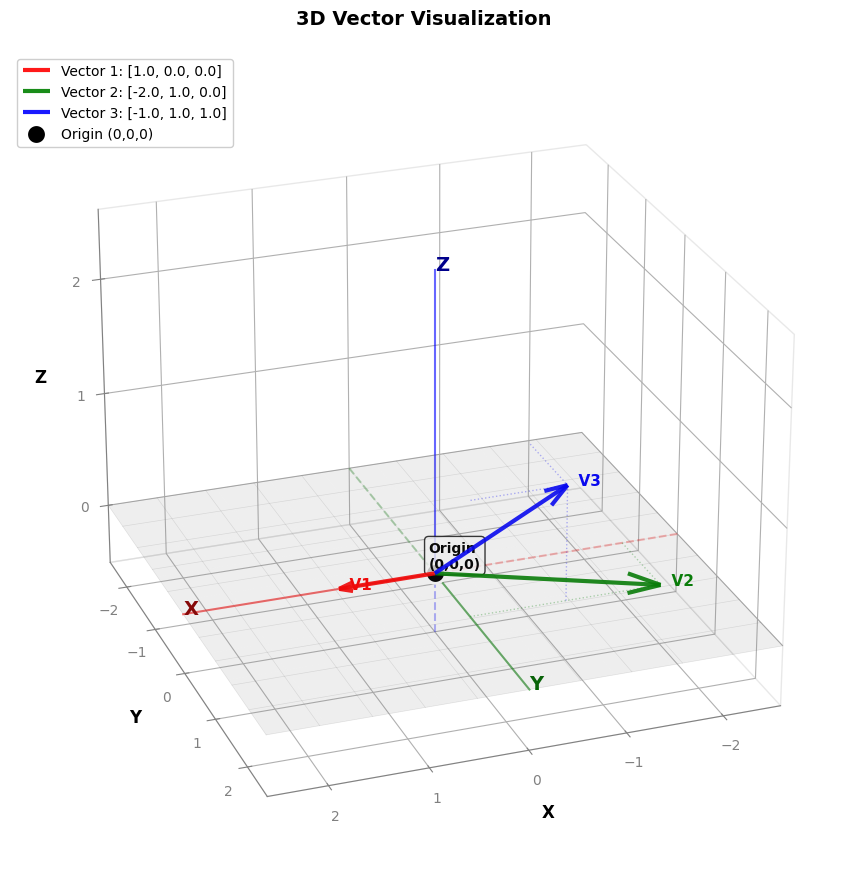

In [8]:
from vector_viz import plot_3d_vectors

plot_3d_vectors(hidden_states)

## Time for self-attention!

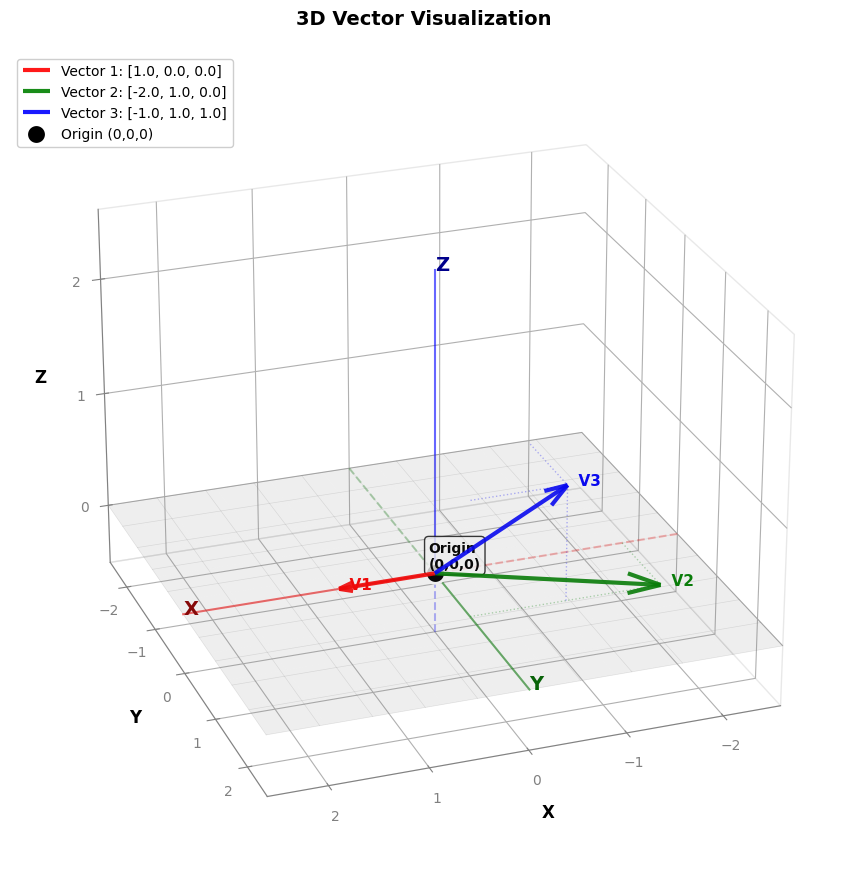

In [11]:
import torch

torch.set_printoptions(precision=2, sci_mode=False)

hidden_states = torch.tensor(
    [[1,0,0],
    [-2,1,0],
    [-1,1,1]],
    dtype=torch.float32,
)
universal_weight = torch.tensor(
    [[2,1,1],
    [4,-6,0],
    [-2,7,2]],
    dtype=torch.float32,
    requires_grad=True)

d_hidden = 3
w_query = torch.nn.Linear(in_features=d_hidden, out_features=d_hidden, bias=False)
w_query.weight.data = universal_weight.T

w_key = torch.nn.Linear(in_features=d_hidden, out_features=d_hidden, bias=False)
w_key.weight.data = universal_weight.T

w_value = torch.nn.Linear(in_features=d_hidden, out_features=d_hidden, bias=False)
w_value.weight.data = universal_weight.T

queries = w_query(hidden_states)
plot_3d_vectors(hidden_states)

we have queries
tensor([[ 2.,  1.,  1.],
        [ 0., -8., -2.],
        [ 0.,  0.,  1.]], grad_fn=<MmBackward0>)


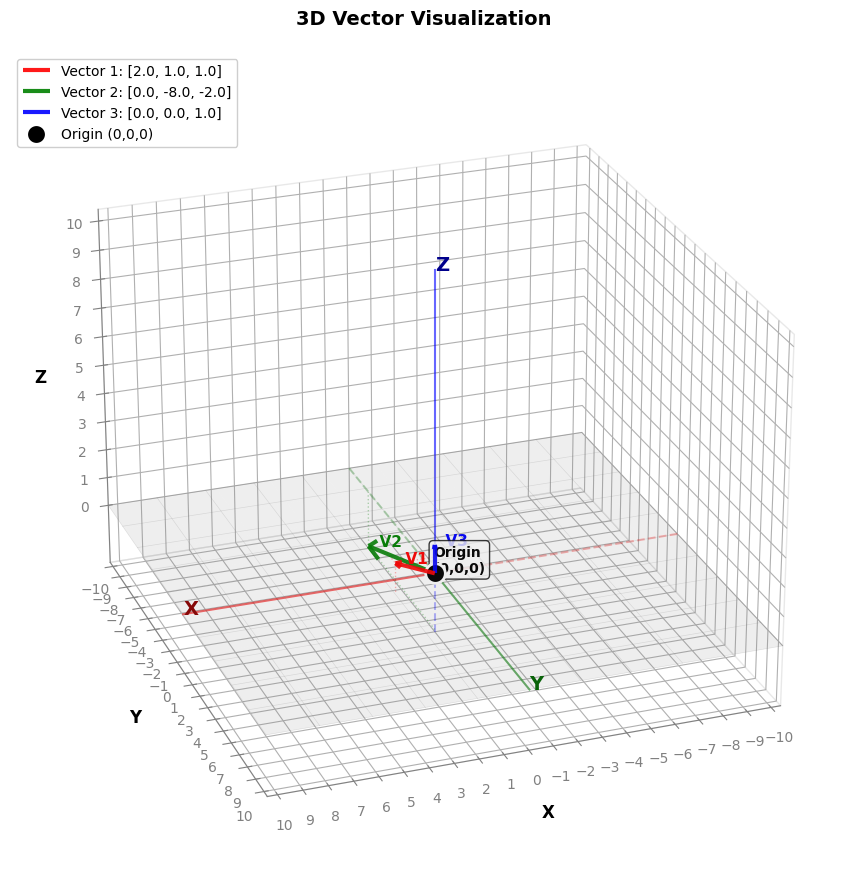

In [12]:
print("we have queries")
print(queries)
plot_3d_vectors(queries)

In [ ]:
keys = w_key(hidden_states)
print("we have keys.T")
print(keys.T)
plot_3d_vectors(keys.T)

key_val_t = torch.matmul(queries, keys.T)
print("we have key_val_t")
print(key_val_t)
plot_3d_vectors(key_val_t)

we have attention map before softmax 0.50
tensor([[ 3.00, -5.00,  0.50],
        [-5.00, 34.00, -1.00],
        [ 0.50, -1.00,  0.50]], grad_fn=<MulBackward0>)


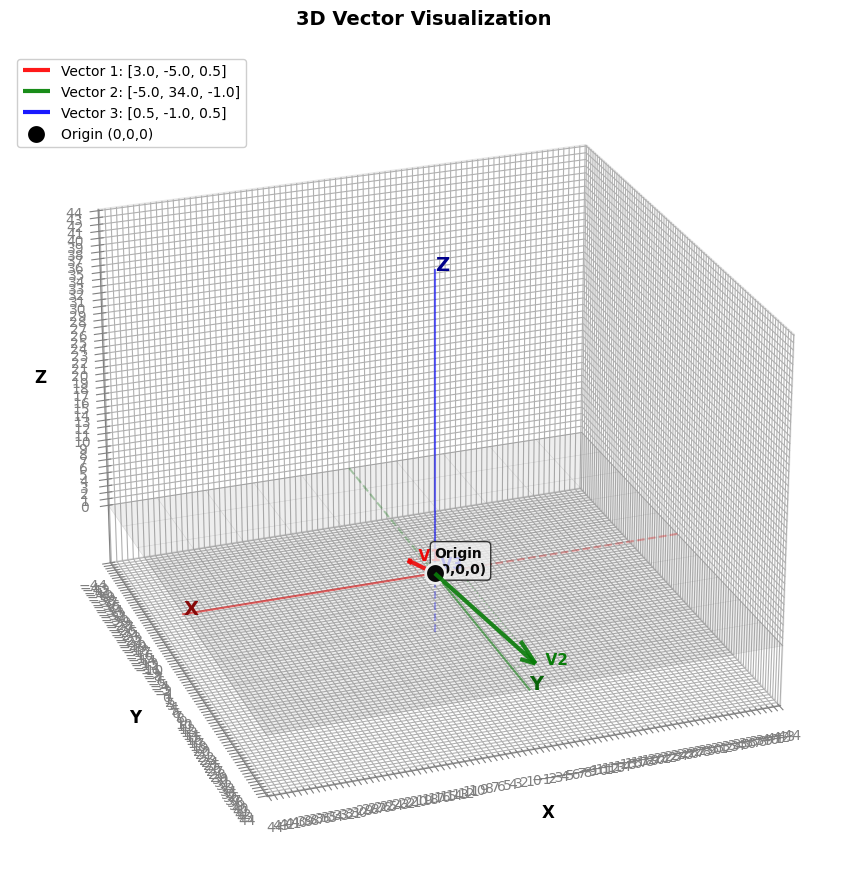

In [13]:
# scaling_factor = torch.sqrt(torch.tensor(d_hidden, dtype=torch.float32))
scaling_factor = 4.0 ** -0.5
attention_map_pre_sm = key_val_t * scaling_factor # this way we avoid grad_fn=<DivBackward0> and instead get grad_fn=<MulBackward0>. H100s are highly optimized for both but claude estimates 0.1-0.4% speedup on Llama 3 8b pretrain scale

print(f"we have attention map before softmax {scaling_factor:.2f}")
print(attention_map_pre_sm)
plot_3d_vectors(attention_map_pre_sm)

we have attention map
tensor([[    0.92,     0.00,     0.08],
        [    0.00,     1.00,     0.00],
        [    0.45,     0.10,     0.45]], grad_fn=<SoftmaxBackward0>)


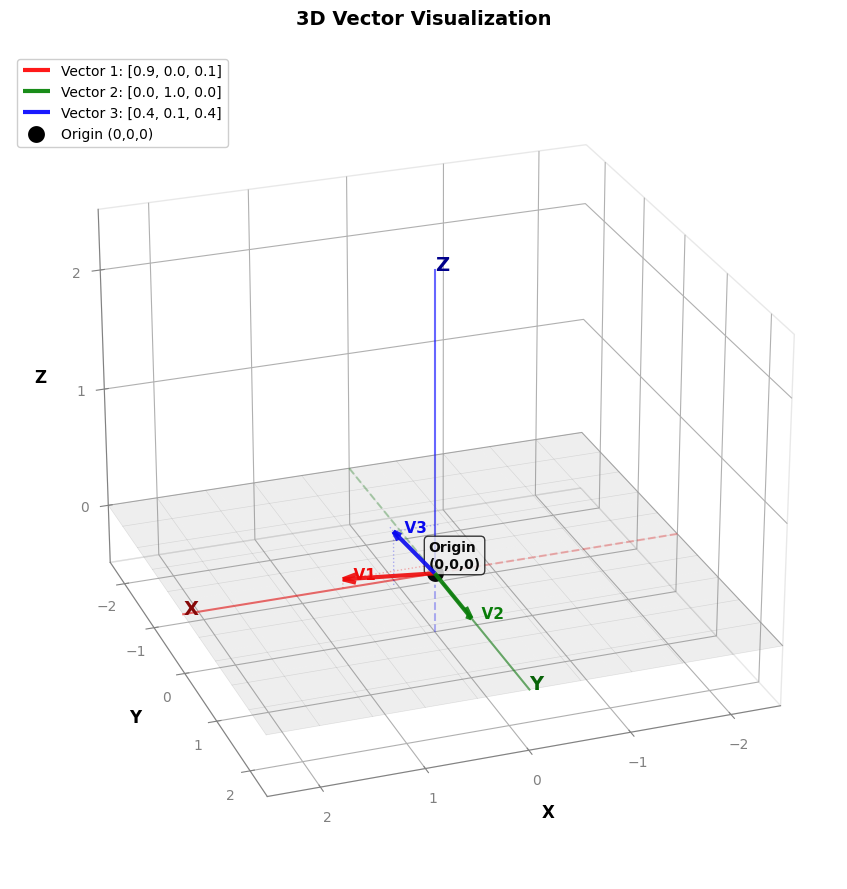

In [14]:
attention_map = torch.nn.functional.softmax(attention_map_pre_sm, dim=-1, dtype=torch.float32).to(queries.dtype)
print("we have attention map")
print(attention_map)
plot_3d_vectors(attention_map)